# Heat Stress
This breaks down each contribution to the theoretical scaling factor.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, R, radius_earth
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean

In [30]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)
p_surface_approx = np.inf          # Desired approximate pressure of surface (hPa)

# Load dataset
exp_dir = 'rossbypalooza/lat_20/'
# rot_rate = [0.25, 0.5, 1, 2, 4]
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/'
rot_rate = ['rot_0_5x', 'base', 'rot_2x']
# exp_dir = 'rossbypalooza/lat_20/'
# rot_rate = [1]
# exp_dir = 'rossbypalooza/depth=20/lat_10/'                # land with fixed SST
# rot_rate = ['base', 'rough']
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/ras_conv/'

# only keep variables required to compute relative humidity and MSE
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag', 'swdn_toa', 'olr', 't_surf', 'precipitation', 'ucomp', 'omega']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']
# rot_rate = [1, 2]
n_exp = len(rot_rate)
exp_names = [f'{rot_rate[i]}'.replace('.', '_') for i in range(len(rot_rate))]
color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
ds = []
albedo = []
tau_sw = []
tau_lw = []
omega = []
time_start = 100
time_final = 9999999999999999
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for j in range(n_exp):
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[j]).sel(time=slice(time_start, time_final))
        
        ds += [ds_use.sel(pfull=[p_surface_approx, pressure_ft], 
                          method='nearest')[var_keep].load()]  # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        omega += [namelist['constants_nml']['omega']]
        pbar.update(1)
omega = np.asarray(omega)        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size

  0%|          | 0/3 [00:00<?, ?it/s]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
 33%|███▎      | 1/3 [00:20<00:40, 20.12s/it]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
 67%|██████▋   | 2/3 [00:39<00:19, 19.61s/it]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
100%|██████████| 3/3 [00:58<00:00, 19.66s/it]


In [31]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(pfull)), pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [32]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


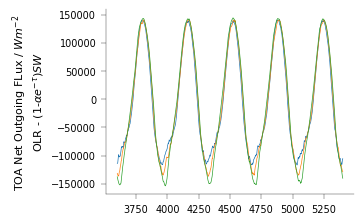

In [33]:
# Plot evolution of net flux and temperature to see how long it takes to spin up
def plot_spinup(ds_array, ax, albedo, tau, ds_name):
    for i, ds_use in enumerate(ds_array):
        # Need to do area weighting so higher latitudes contribute less to reflect their area
        olr_sum = area_weighting(ds_use.olr).sum(dim = ['lon', 'lat'])
        short_wave_sum = area_weighting(ds_use.swdn_toa).sum(dim = ['lon', 'lat'])
        # Include surface albedo which reflects all SW radiation reaching it
        # SW radiation reaching it has been reduced by that absorbed in the atmosphere - non zero short wave optical depth.
        # There is no absorption on return trip from surface to space though hence just the one factor.
        net_flux = olr_sum - short_wave_sum*(1-albedo*np.exp(-tau))
        # net_flux = olr_sum - short_wave_sum
        ax.plot(ds_use.time, net_flux)
    ax.set_ylabel('TOA Net Outgoing FLux / $Wm^{-2}$\nOLR - (1-$\\alpha e^{-\\tau})SW$')
    ax.legend()

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
plot_spinup(ds, ax, albedo[0], tau_sw[0], rot_rate)

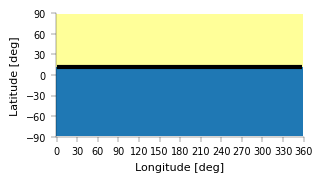

In [34]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]       # get the longitude coordinates of land
    lat_land_min = float(lat_land.min())
    lat_land_max = float(lat_land.max())
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
else:
    lat_land_min = None
    lat_land_max = None

def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lat_ax == 'x':
                var = ax[i].get_ylim()[0]
                xlim = ax[i].get_xlim()
                ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_ylim(var, ax[i].get_ylim()[1])
                ax[i].set_xlim(xlim)
            elif lat_ax == 'y':
                var = ax[i].get_xlim()[0]
                ylim = ax[i].get_ylim()
                ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_xlim(var, ax[i].get_xlim()[1])
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

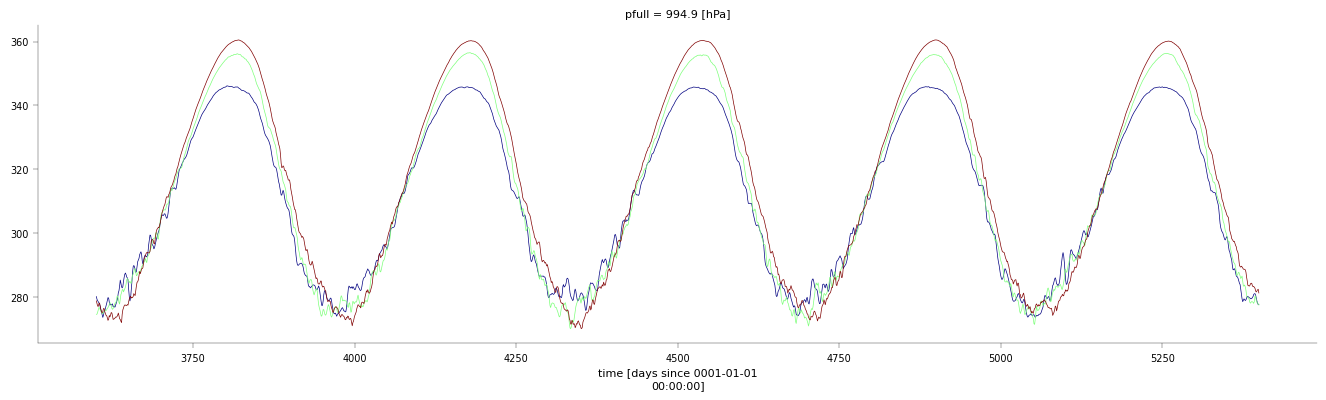

In [35]:
fig, ax = plt.subplots(1,1, figsize=(3*width['two_col'], width['two_col']/ar))
for i in range(n_exp):
    moist_static_energy(ds[i].temp.isel(pfull=ind_surf), ds[i].sphum.isel(pfull=ind_surf), ds[i].height.isel(pfull=ind_surf)
                        ).mean(dim='lon').sel(lat=slice(25, 35)).mean(dim='lat').plot(color=color_seq_rot[i], ax=ax)

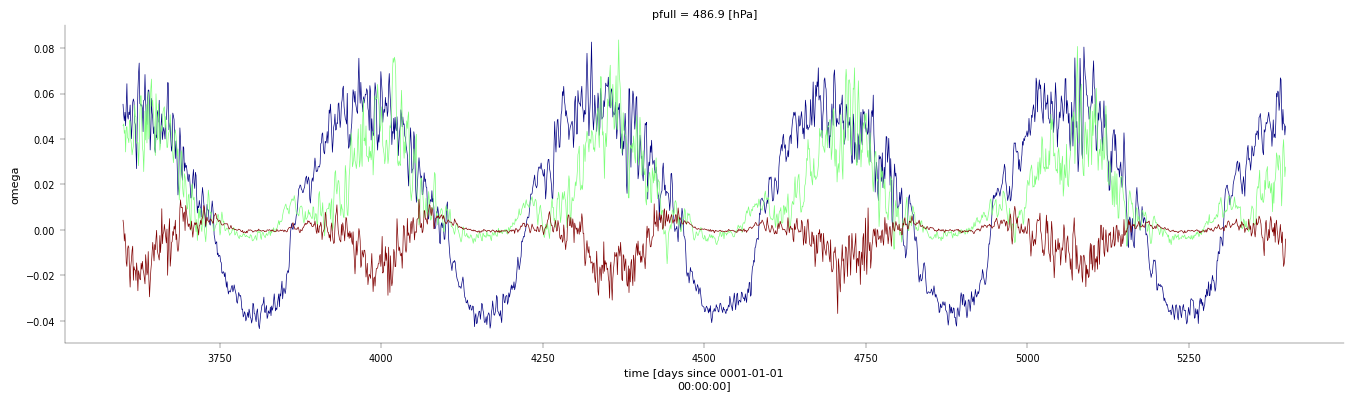

In [36]:
fig, ax = plt.subplots(1,1, figsize=(3*width['two_col'], width['two_col']/ar))
for i in range(n_exp):
    ds[i].omega.isel(pfull=ind_ft).sel(lat=slice(25, 35)).mean(dim=['lat', 'lon']).plot(color=color_seq_rot[i], ax=ax)

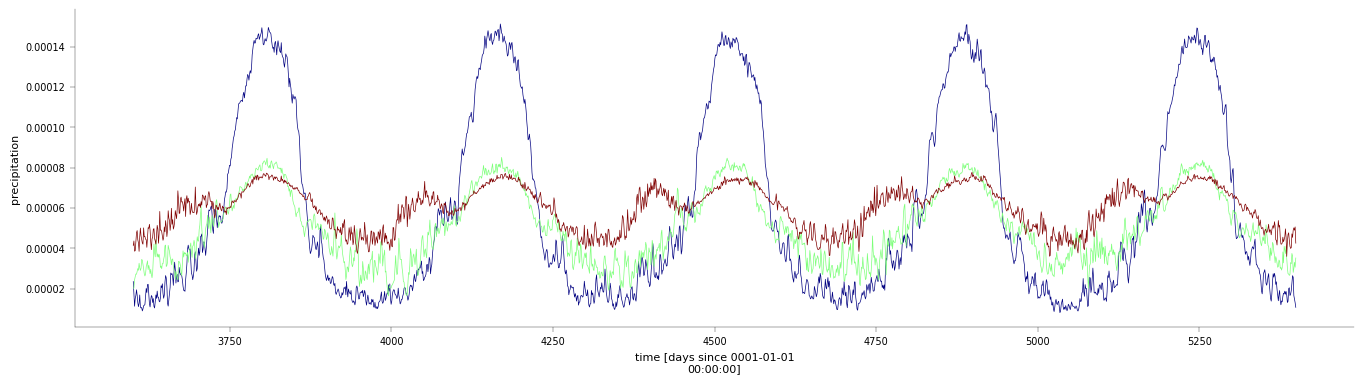

In [37]:
fig, ax = plt.subplots(1,1, figsize=(3*width['two_col'], width['two_col']/ar))
for i in range(n_exp):
    ds[i].precipitation.sel(lat=slice(25, 35)).mean(dim=['lat', 'lon']).plot(color=color_seq_rot[i], ax=ax)

In [38]:
mse = [moist_static_energy(ds[i].temp.isel(pfull=ind_surf), ds[i].sphum.isel(pfull=ind_surf), 0).mean(dim='lon') for i in range(n_exp)]

(-10.0, 50.0)

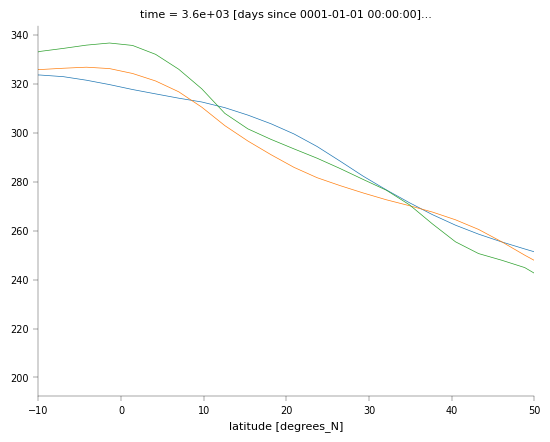

In [39]:
for i in range(n_exp):
    mse[i].sel(time=560, method='nearest').plot()
plt.xlim(-10, 50)

### MSE as function of rotation rate
In summer (JJA), expect near-surface MSE to be peaked off-equator, and size of peak relative to equator to increase with rotation rate. We show that we do see this below.

In [52]:
summer_months = [6, 7, 8]
ds_av_summer = [annual_time_slice(ds[i], include_months=summer_months).mean(dim=['time', 'lon']) for i in range(n_exp)]
mse_av_summer = [moist_static_energy(ds_av_summer[i].temp.isel(pfull=ind_surf), ds_av_summer[i].sphum.isel(pfull=ind_surf), 
                                     ds_av_summer[i].height.isel(pfull=ind_surf)) for i in range(n_exp)]
mse_ft_av_summer = [moist_static_energy(ds_av_summer[i].temp.isel(pfull=ind_ft), 
                                        sphum_sat(ds_av_summer[i].temp.isel(pfull=ind_ft), pressure_ft_actual), 
                                        ds_av_summer[i].height.isel(pfull=ind_ft)) for i in range(n_exp)]

In [53]:
# Need to average over subtropics and over equator, specify these regions here
lat_subtrop_min = 25
lat_subtrop_max = 40

lat_equator_min = -10
lat_equator_max = 10

(-60.0, 60.0)

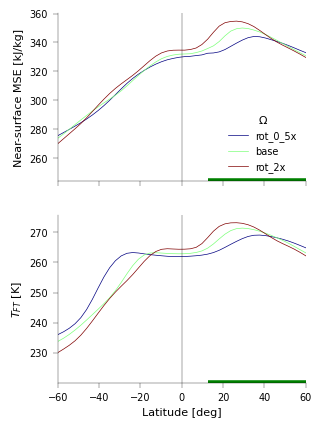

In [54]:
color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds[0].lat, mse_av_summer[i], color=color_seq_rot[i], label=rot_rate[i])
    ax[1].plot(ds[0].lat, ds_av_summer[i].temp.isel(pfull=ind_ft), color=color_seq_rot[i], label=rot_rate[i])
# ax[0].set_xlim(-10, 50)
# ax[0].set_ylim(270, 300)
# ax[1].set_ylim(250, 275)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
show_land(ax)
ax[0].legend(title='$\Omega$')
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Near-surface MSE [kJ/kg]')
ax[1].set_ylabel('$T_{FT}$ [K]')
ax[0].set_xlim(-60, 60)

Text(0, 0.5, '$h_s - h_{FT}^*$ [kJ/kg]')

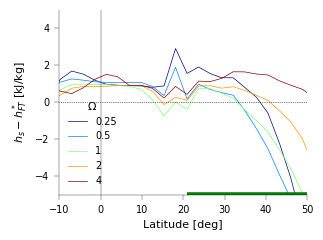

In [16]:
color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(ds[0].lat, mse_av_summer[i] - mse_ft_av_summer[i], color=color_seq_rot[i], label=rot_rate[i])
ax.set_xlim(-10, 50)
ax.set_ylim(-5, 5)
show_land([ax])
ax.axvline(0, color='k', lw=ax_linewidth)
ax.axhline(0, color='k', linestyle=':')
ax.legend(title='$\Omega$')
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$h_s - h_{FT}^*$ [kJ/kg]')

In [17]:
# MSE_diff is difference between subtropics and equatorial MSE
mse_diff = np.asarray([float(mse_av_summer[i].sel(lat=slice(lat_subtrop_min, lat_subtrop_max)).mean() - 
            mse_av_summer[i].sel(lat=slice(lat_equator_min, lat_equator_max)).mean()) for i in range(n_exp)])
mse_lat_peak = np.asarray([float(ds[0].lat[mse_av_summer[i].argmax()]) for i in range(n_exp)])

temp_ft_diff = np.asarray([float(ds_av_summer[i].temp.isel(pfull=ind_ft).sel(lat=slice(lat_subtrop_min, lat_subtrop_max)).mean() - 
            ds_av_summer[i].temp.isel(pfull=ind_ft).sel(lat=slice(lat_equator_min, lat_equator_max)).mean()) for i in range(n_exp)])

In [18]:
# def omega_power_scaling(omega, power, m, c):
#     return m * omega**power
# 
# mse_fit_params = scipy.optimize.curve_fit(omega_power_scaling, omega, mse_diff, p0=[0.5, 1557.93018518, 0])[0]
# omega_array = np.linspace(0, 0.0003, 30)
# 
# fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
# ax.plot(omega, mse_diff, marker='o')
# ax.plot(omega_array, omega_power_scaling(omega_array, *mse_fit_params), color='k', linestyle=':')
# ax.plot(np.log10(omega), temp_ft_diff, marker='o')
# ax.set_ylabel('$\Delta$ MSE [kJ/kg]')
# ax.set_xlabel('$\Omega$ [s$^{-1}$]')
# ax.set_xlim(0, 0.0003)
# ax.set_ylim(0, 25)
# print('Fit results: Power = {:.2f}, Gradient = {:.0f}, Intercept = {:.2f}'.format(mse_fit_params[0], mse_fit_params[1], mse_fit_params[2]))

In [19]:
# fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
# ax.plot(omega**mse_fit_params[0], mse_diff, marker='o')
# ax.plot(omega_array**mse_fit_params[0], mse_fit_params[1]*omega_array**mse_fit_params[0]+mse_fit_params[2], color='k', linestyle=':')
# ax.set_ylim(0, 25)
# ax.set_xlim(0, 0.0003**mse_fit_params[0])
# ax.set_ylabel('$\Delta$ MSE [kJ/kg]')
# ax.set_xlabel('$\Omega**{:.2f}$'.format(mse_fit_params[0]))

(0.0, 0.0003)

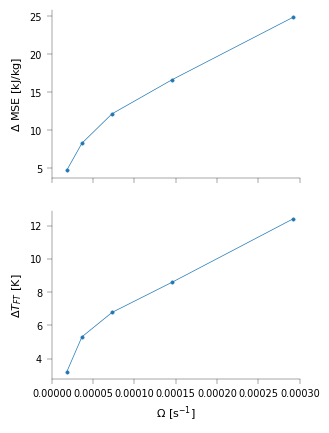

In [20]:
# MSE_diff is difference between subtropics and equatorial MSE
mse_diff = np.asarray([float(mse_av_summer[i].max() -
                             mse_av_summer[i].sel(lat=0, method='nearest')) for i in range(n_exp)])
mse_lat_peak = np.asarray([float(ds[0].lat[mse_av_summer[i].argmax()]) for i in range(n_exp)])

temp_ft_diff = np.asarray([float(ds_av_summer[i].temp.isel(pfull=ind_ft).max() -
                                 ds_av_summer[i].temp.isel(pfull=ind_ft).sel(lat=0, method='nearest')) for i in
                           range(n_exp)])
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2 * width['one_col'] / ar), sharex=True)
ax[0].plot(omega, mse_diff, marker='o')
ax[1].plot(omega, temp_ft_diff, marker='o')
ax[0].set_ylabel('$\Delta$ MSE [kJ/kg]')
ax[1].set_ylabel('$\Delta T_{FT}$ [K]')
ax[1].set_xlabel('$\Omega$ [s$^{-1}$]')
ax[0].set_xlim(0, 0.0003)

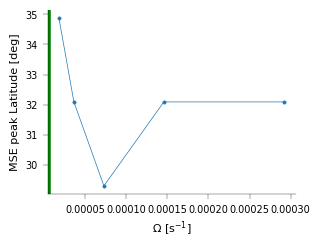

In [21]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(omega, mse_lat_peak, marker='o')
ax.set_xlabel('$\Omega$ [s$^{-1}$]')
ax.set_ylabel('MSE peak Latitude [deg]')
show_land([ax], lat_ax='y')

## Circulation Analysis

Text(0, 0.5, '$u$ [m/s]')

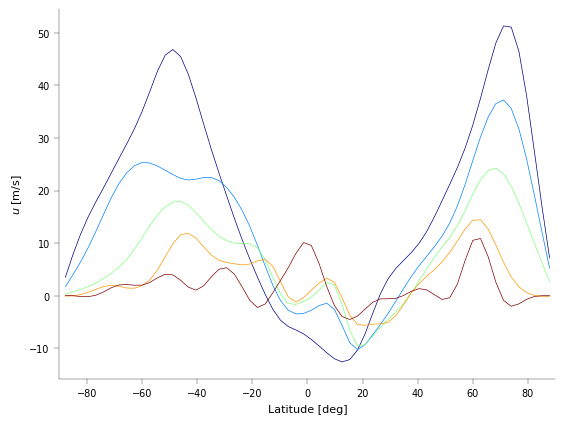

In [22]:
for i in range(n_exp):
    plt.plot(ds[0].lat, ds_av_summer[i].ucomp.isel(pfull=ind_ft), color=color_seq_rot[i])
plt.xlim(-90, 90)
plt.xlabel('Latitude [deg]')
plt.ylabel('$u$ [m/s]')

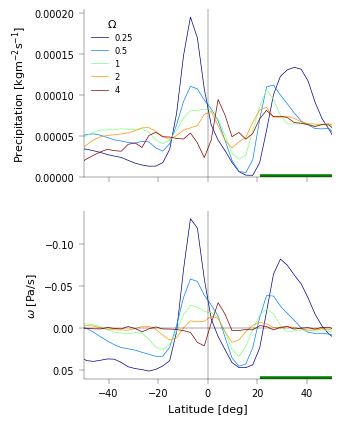

In [23]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds_av_summer[i].lat, ds_av_summer[i].precipitation, color=color_seq_rot[i], label=rot_rate[i])
    ax[1].plot(ds_av_summer[i].lat, ds_av_summer[i].omega.isel(pfull=ind_ft), color=color_seq_rot[i])
ax[0].set_xlim(-50, 50)
ax[0].set_ylim(0, ax[0].get_ylim()[1])
ax[0].legend(title='$\Omega$', fontsize=6)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Precipitation [kgm$^{-2}$s$^{-1}$]')
ax[1].set_ylabel('$\omega$ [Pa/s]')
ax[1].invert_yaxis()
show_land(ax)

In [24]:
ds_circulation = []
for i in tqdm(range(n_exp)):  
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i]).sel(time=slice(time_start, time_final))[['ucomp', 'vcomp', 'omega', 
                                                                                                      'temp', 'precipitation']].load()
    # ds_use = annual_time_slice(ds_use, include_months=[12,1,2]).mean(dim=['time', 'lon'])
    ds_use = annual_time_slice(ds_use, include_months=summer_months).mean(dim=['time', 'lon'])
    ds_circulation += [ds_use]

 20%|██        | 1/5 [01:04<04:17, 64.36s/it]

KeyboardInterrupt



In [ ]:
p_upper_cell = 300
for i in range(n_exp):
    plt.plot(ds[0].lat, ds_circulation[i].ucomp.sel(pfull=p_upper_cell, method='nearest'), color=color_seq_rot[i])
    plt.plot(ds[0].lat, -1000*ds_circulation[i].omega.sel(pfull=500, method='nearest'), color=color_seq_rot[i], linestyle=':')
# ds_use.sel(pfull=200, method='nearest').plot()
# ds_use.sel(pfull=500, method='nearest').plot()
# ds_use.sel(pfull=300, method='nearest').plot()
plt.axhline(0, color='k', linestyle=':')
plt.xlim(-50, 50)

In [ ]:
n_p = ds_circulation[0].pfull.size
n_lat = ds_circulation[0].lat.size
stream = np.zeros((n_exp, n_p, n_lat))
cos_lat = np.asarray(np.cos(np.deg2rad(ds[0].lat)))
ang_mom = np.asarray([(ds_circulation[i].ucomp + omega[i] * radius_earth * cos_lat) * radius_earth * cos_lat for i in range(n_exp)])
for k in range(n_exp):
    for i in range(n_p):
        stream[k, i] = integrate.simpson(y=ds_circulation[k].vcomp[:i+1], x=ds_circulation[k].pfull[:i+1] * 100, axis=0)
        stream[k, i] = -2 * np.pi * radius_earth * cos_lat[np.newaxis] / g * stream[k, i]  # get into correct units of kg/s

In [ ]:
vmax = np.abs(stream).max()
fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
step_level = 50e9/2
levels_stream = np.arange(-np.max(np.abs(stream)), np.max(np.abs(stream))+step_level, step_level)
for i in range(n_exp):
    # im = ax[i].pcolormesh(ds_circulation[0].lat, ds_circulation[0].pfull, stream[i], 
    #                       cmap='bwr', shading='gouraud', vmin=-vmax, vmax=vmax)
    ax[i].contour(ds_circulation[0].lat, ds_circulation[0].pfull, stream[i], colors='k', levels=levels_stream)
    ax[i].contour(ds_circulation[0].lat, ds_circulation[0].pfull, ang_mom[i], colors='r')
    ax[i].set_title(str(rot_rate[i])+'$\\times \Omega_E$')
ax[0].set_xlim(-45, 45)
ax[0].invert_yaxis()
show_land(ax)
ax[0].set_ylabel('Pressure [hPa]')
fig.supxlabel('Latitude [deg]', y=-0.03, fontsize=8)

In [ ]:
vmax = np.max([np.abs(ds_circulation[i].omega).max() for i in range(n_exp)])
vmax_precip = np.max([np.abs(ds_circulation[i].precipitation).max() for i in range(n_exp)])*1000
color_precip = 'green'
fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
ax2 = [ax[i].twinx() for i in range(n_exp)]
for i in range(n_exp):
    im = ax[i].pcolormesh(ds_circulation[0].lat, ds_circulation[0].pfull, ds_circulation[i].omega, 
                          cmap='bwr', shading='gouraud', vmin=-vmax, vmax=vmax)
    ax[i].contour(ds_circulation[0].lat, ds_circulation[0].pfull, stream[i], colors='k', levels=levels_stream, alpha=0.2)
    # label where get peak MSE
    ax[i].axvline(mse_av_summer[i].lat[mse_av_summer[i].argmax(dim='lat')], color='k', lw=ax_linewidth)
    ax[i].set_title(str(rot_rate[i])+'$\\times \Omega_E$')
    ax2[i].plot(ds_circulation[0].lat, ds_circulation[i].precipitation*1000, color=color_precip, alpha=0.7)
ax[0].invert_yaxis()
show_land(ax)
ax[0].set_xlim(-45, 45)
ax[0].set_ylabel('Pressure [hPa]')
for i in range(n_exp):
    ax2[i].spines.right.set_visible(True)
    ax2[i].spines.right.set_color(color_precip)
    ax2[i].spines.left.set_visible(False)
    ax2[i].spines.bottom.set_visible(False)
    ax2[i].tick_params(axis='y', colors=color_precip)
    ax2[i].set_ylim(0, vmax_precip)
    if i<n_exp-1:
        ax2[i].yaxis.set_ticklabels([])
    else:
        ax2[i].set_ylabel('Precipitation [gm$^{-2}$s$^{-1}$]', color=color_precip)
fig.supxlabel('Latitude [deg]', y=-0.03, fontsize=8);

In [ ]:
n_year_days = 360
wind_pressure_ft = np.zeros((n_exp, n_year_days, ds[0].coords['lat'].size))
precipitation_annual_mean = np.zeros((n_exp, n_year_days, ds[0].coords['lat'].size))
convflag_annual_mean = np.zeros((n_exp, n_year_days, ds[0].coords['lat'].size))
klzbs_annual_mean = np.zeros((n_exp, n_year_days, ds[0].coords['lat'].size))
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[['omega', 'precipitation', 'convflag', 'klzbs']]
    ds_use = ds_use.sel(pfull=pressure_ft, method='nearest')       # just keep free troposphere pressure
    # Take zonal and time mean
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).mean(dim='lon')
    ds_use = annual_mean(ds_use).load()
    wind_pressure_ft[i] = ds_use.omega.to_numpy()
    precipitation_annual_mean[i] = ds_use.precipitation.to_numpy()
    convflag_annual_mean[i] = ds_use.convflag.to_numpy()
    klzbs_annual_mean[i] = ds_use.klzbs.to_numpy()

In [ ]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(1,n_exp, figsize=(n_exp*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(wind_pressure_ft[i]), cmap='bwr', vmin=-0.2, vmax=0.2)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
show_land(ax, lat_ax='y')
plt.colorbar(im, ax=ax, label='$[\omega]$ / $Pas^{-1}$')
ax[0].set_ylim(-45, 45)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude')
ax[0].set_title(f'Vertical velocity at $p={pressure_ft}hPa$');

In [ ]:
vmax = np.max(precipitation_annual_mean)
fig, ax = plt.subplots(1,n_exp, figsize=(n_exp*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(precipitation_annual_mean[i])*1000, vmin=0, vmax=vmax*1000)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylim(-45, 45)
show_land(ax, lat_ax='y', color_land='r')
plt.colorbar(im, ax=ax, label='Precipitation [gm$^{-2}$s$^{-1}$]')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

In [ ]:
fig, ax = plt.subplots(1,n_exp, figsize=(n_exp*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(convflag_annual_mean[i]), vmin=0, vmax=2, cmap='bwr_r')
    ax[i].axhline(0, color='k', lw=ax_linewidth)
show_land(ax, lat_ax='y')
ax[0].set_ylim(-45, 45)
plt.colorbar(im, ax=ax, label='Convflag')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

In [ ]:
fig, ax = plt.subplots(1,n_exp, figsize=(n_exp*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(lzb(klzbs_annual_mean[i])), vmin=200, vmax=800, cmap='bwr')
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylim(-45, 45)
show_land(ax, lat_ax='y')
plt.colorbar(im, ax=ax, label='LNB [hPa]')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

In [ ]:
fig, ax = plt.subplots(1,n_exp, figsize=(n_exp*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, annual_mean(ds[i].t_surf.mean(dim='lon')).transpose(), vmin=280, vmax=330)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylim(-45, 45)
show_land(ax, lat_ax='y', color_land='r')
plt.colorbar(im, ax=ax, label='Surface temperature [K]')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

In [ ]:
fig, ax = plt.subplots(1,n_exp, figsize=(n_exp*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    rh_use = ds[i].sphum.isel(pfull=ind_surf)*1000# /sphum_sat(ds[i].temp.isel(pfull=ind_surf), p_surface) * 100
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, annual_mean(rh_use.mean(dim='lon')).transpose(), vmin=0, vmax=16)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylim(-45, 45)
show_land(ax, lat_ax='y', color_land='r')
plt.colorbar(im, ax=ax, label='Specific Humidity [g/kg]')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

### Angular Momentum
The zonal wind contribution (dotted line) to the mean summer angular momentum is very small. The angular momentum at the top of the cell (300hPa) is thus clearly not constant with latitude.

In [ ]:
ang_mom_ucomp = np.zeros((n_exp, n_lat))
ang_mom_omega_comp = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    ang_mom_ucomp[i] = ds_circulation[i].ucomp.sel(pfull=p_upper_cell, method='nearest') * cos_lat * radius_earth
    ang_mom_omega_comp[i] = omega[i] * cos_lat * radius_earth * cos_lat * radius_earth

In [ ]:
ind_equator = int(np.abs(ds[0].lat).argmin())

In [ ]:
for i in range(n_exp):
    plt.plot(ds[0].lat, (ang_mom_ucomp[i]+ang_mom_omega_comp[i])/(ang_mom_ucomp[i]+ang_mom_omega_comp[i])[ind_equator], color=color_seq_rot[i])
    # plt.plot(ds[0].lat, ang_mom_ucomp[i]+ang_mom_omega_comp[i], color=color_seq_rot[i], linestyle=':')
    # plt.plot(ds[0].lat, ang_mom_omega_comp[i], color=color_seq_rot[i], linestyle='-')
plt.plot(ds[0].lat, (ang_mom_omega_comp[i])/(ang_mom_omega_comp[i])[ind_equator], color='k', lw=5, alpha=0.2)
# ds_use.sel(pfull=200, method='nearest').plot()
# ds_use.sel(pfull=500, method='nearest').plot()
# ds_use.sel(pfull=300, method='nearest').plot()
# plt.axhline(0, color='k', linestyle='-', lw=ax_linewidth)
plt.xlim(-10, 60)
plt.ylim(0.2, 1.05)
plt.axvline(0, color='k', lw=ax_linewidth)
plt.axvline(lat_land_min, color='k', linestyle=':')
plt.xlabel('Latitude [deg]')
plt.ylabel(f'Angular Momentum ({p_upper_cell}hPa)');
# plt.ylim(-0.1e10, 1.25e10)

In [ ]:
def get_u_thermal(ds, rot_rate):
    # Axis 0 is pressure, axis 1 is latitude and axis 2 is lon_time or not included
    # Equation 1 in the paper
    pressure = ds.pfull.to_numpy() * 100
    if 'lon' in ds:
        integrand = np.gradient(ds.temp, np.deg2rad(ds.lat), axis=1)/pressure[:, np.newaxis, np.newaxis]
        f_coriolis = 2 * rot_rate * np.sin(np.deg2rad(ds.lat).to_numpy())[:, np.newaxis]
    else:
        integrand = np.gradient(ds.temp, np.deg2rad(ds.lat), axis=1)/pressure[:, np.newaxis]
        f_coriolis = 2 * rot_rate * np.sin(np.deg2rad(ds.lat).to_numpy())
    return scipy.integrate.simpson(integrand, pressure, axis=0) * R/(radius_earth * f_coriolis)

u_thermal = np.zeros((n_exp, n_lat))
u_ang_mom_cons = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    u_thermal[i] = get_u_thermal(ds_circulation[i].sel(pfull=slice(p_upper_cell, np.inf)).isel(pfull=slice(None, None, -1)), omega[i])
    u_ang_mom_cons[i] = omega[i] * radius_earth * (np.cos(np.deg2rad(35))**2-cos_lat**2)/cos_lat

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col']*2, width['one_col']*2/ar))
for i in range(n_exp):
    ax.plot(ds_circulation[i].lat, ds_circulation[i].sel(pfull=p_upper_cell, method='nearest').ucomp, color=color_seq_rot[i], lw=1)
    ax.plot(ds_circulation[i].lat, u_thermal[i], color=color_seq_rot[i], linestyle='--', lw=1)
    ax.plot(ds_circulation[i].lat, u_ang_mom_cons[i], color=color_seq_rot[i], linestyle=':', lw=1)
ax.set_xlim(-10, 60)
ax.set_ylim(-40, 50)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel(f'$u$ ({p_upper_cell}hPa) [m/s]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.axvline(lat_land_min, color='k', linestyle=':')
show_land([ax])